## Vector-valued function with Random Fourier Features

### Imports

In [37]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import time
from functools import wraps

### Runtime

In [38]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Values

In [39]:
dimension = 2
sigma = 10
sigma2 = 2*sigma**2

# Random Fourier features
m = 20 # number of samples
w = np.array([randn(m) / sigma, randn(m) / sigma]) # w is the same size as the dimensions times the number of samples
b = np.random.rand(m)*2*np.pi # b is the same size as number of samples

n = 500 # number of points

x1 = randn(n)/2
x2 =  randn(n)/2
x_vector = np.array([x1, x2])
# x_vector = np.block([x1,x2])

noise = randn(n) * 1e-1
#y1 = np.cos(x1) + noise
#y2 = np.sin(x2) + noise

y1 = 1+np.sin(x1/10) + x1**2 + noise
y2 = 0.5 * x2**2 + np.exp(x2) + noise

y = np.array(np.ravel([y1, y2], 'F'))

lam = 0.000001 # Regularization parameter
y.shape

(1000,)

### Gaussian Kernel

In [40]:
def k_gauss(x, z):
    k = np.exp(-((np.linalg.norm(x-z))**2)/(2*sigma**2))
    return k

def k_matrix(x, z, dim):
    k = k_gauss(x, z)
    k_matrix = k *np.eye(dim)
    return k_matrix

@runtime
def K_gauss(x, n, dim):
    K = np.zeros((dim*n, dim*n))
    for i in range(0, n):
        for j in range(0, n):
            k = k_gauss(x[:,i], x[:,j])
            K[i*dim][j*dim] = k
            K[i*dim+1][j*dim+1] = k
    return K

K = K_gauss(x_vector, n, dimension)



 Function K_gauss took 2.2944 seconds


#### Alpha

In [41]:
# Returns a vector with length dim * n
@runtime
def alpha(x, y, lam, n, dim):
    K = K_gauss(x, n, dim)
    alpha_vector = np.linalg.inv((K + lam*np.eye(dim*n))) @ y
    alpha_reshape = [alpha_vector[::2], alpha_vector[1::2]]
    return np.array(alpha_reshape)

alpha_ = alpha(x_vector, y, lam, n, dimension)



 Function K_gauss took 2.6187 seconds

 Function alpha took 2.8285 seconds


#### Estimated function

In [42]:
@runtime
def estimated_function(alpha, x, n, dim):
    function = np.zeros((2, n))
    for i in range(n):
        sum = np.zeros((2))
        x_i = x[:, i]
        for j in range(n):
            k = k_gauss(x_i, x[:, j])
            kernel = k*np.eye(dim)
            sum = sum + kernel@alpha[:, j]
        function[:, i] = sum 
    return function

func = estimated_function(alpha_, x_vector, n, dimension)
func


 Function estimated_function took 5.6181 seconds


array([[1.15357104, 1.07189232, 1.17259799, 1.61871923, 1.14135076,
        1.45910947, 2.19374874, 1.05429623, 1.36214067, 1.48765729,
        1.06982864, 1.19095977, 1.22876162, 1.48012652, 2.08032268,
        0.99863514, 1.39174814, 1.08177097, 1.48233946, 1.01691241,
        1.02700768, 1.21574019, 2.5705885 , 1.01842048, 1.00181984,
        1.06673079, 1.24634156, 1.69719859, 1.06997131, 1.0260478 ,
        1.00982277, 1.05601876, 1.394074  , 1.08344053, 1.00707468,
        1.17769352, 1.98623541, 1.04367467, 1.00343769, 1.38572675,
        1.15015016, 1.35114221, 1.42170221, 1.04795158, 1.004308  ,
        1.06262916, 1.20076071, 1.03848663, 1.00588372, 1.06664531,
        1.32193888, 1.24822537, 1.36369409, 1.46536684, 1.07866158,
        0.99823997, 1.02623703, 1.03774146, 1.07928762, 1.42509874,
        1.20764484, 1.04329655, 1.110655  , 1.02200594, 1.02719073,
        1.19742866, 1.1551391 , 1.04559124, 1.11981217, 1.02950301,
        1.25061655, 1.01870382, 1.66226817, 1.14

#### Plot

C:\Users\Heli\AppData\Local\Temp\ipykernel_14636\2062984262.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
C:\Users\Heli\AppData\Local\Temp\ipykernel_14636\2062984262.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


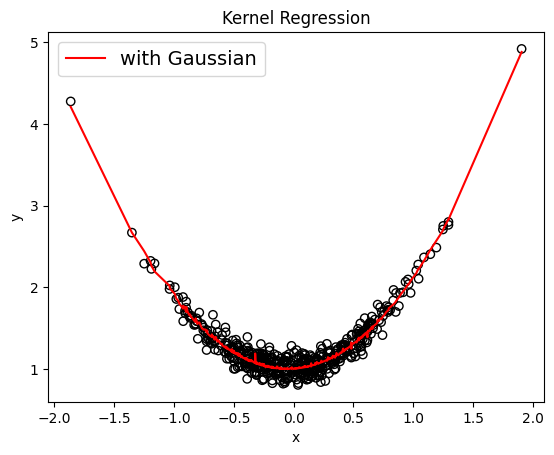

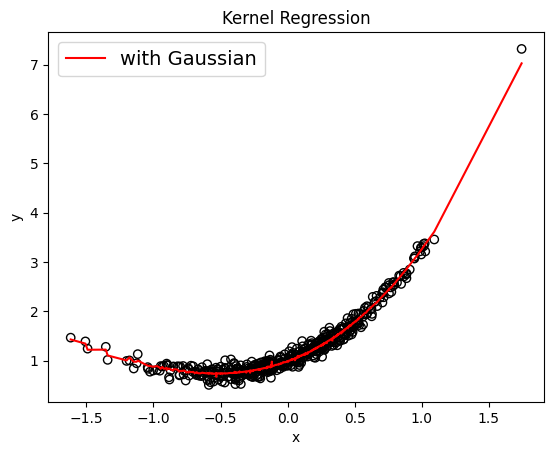

In [43]:
# Plot for x1 and y1
f1_sort = np.array([x for _,x in sorted(zip(x1,func[0]))])

f = plt.figure(1)
plt.scatter(x1,y1, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(np.sort(x1), f1_sort, c="r", label="with Gaussian")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
f.show()

# Plot for x2 and y2
f2_sort = np.array([x for _,x in sorted(zip(x2,func[1]))])

g = plt.figure(2)
plt.scatter(x2,y2, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(np.sort(x2), f2_sort, c="r", label="with Gaussian")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
g.show()

### With Random Fourier Features

#### Psi

In [44]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, m):
    psi_vector = np.zeros(m)
    for i in range(m):
        psi_vector[i] = psi(x, w[:, i], b[i])
    return np.array(psi_vector)

def capital_psi(x, w,b, m, dim):
    psi = psi_vector(x,w,b,m)
    return np.kron(psi, np.eye(dim))

capital_psi(x_vector[:, 1], w, b, m, dimension)

array([[ 0.25828637,  0.        , -1.18123794, -0.        ,  0.66998216,
         0.        , -0.88383579, -0.        , -0.2102434 , -0.        ,
         0.99973141,  0.        , -0.76917697, -0.        , -0.59129607,
        -0.        ,  1.21008991,  0.        , -0.02235336, -0.        ,
         0.65662399,  0.        , -0.98861465, -0.        ,  1.41011295,
         0.        ,  1.23967257,  0.        ,  0.68341676,  0.        ,
        -1.40530076, -0.        ,  1.0884254 ,  0.        , -0.55399551,
        -0.        ,  1.35530637,  0.        ,  0.47249405,  0.        ],
       [ 0.        ,  0.25828637, -0.        , -1.18123794,  0.        ,
         0.66998216, -0.        , -0.88383579, -0.        , -0.2102434 ,
         0.        ,  0.99973141, -0.        , -0.76917697, -0.        ,
        -0.59129607,  0.        ,  1.21008991, -0.        , -0.02235336,
         0.        ,  0.65662399, -0.        , -0.98861465,  0.        ,
         1.41011295,  0.        ,  1.23967257,  0.

#### Phi

In [45]:
def phi(x, w, b, n, m, dim):
    phi = np.zeros((dim*n, dim*m))
    for i in range(0, n):
        psi = capital_psi(x[:,i], w, b, m, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

phi_ = phi(x_vector, w, b, n, m, dimension)

array([[ 0.30022903,  0.        , -1.08354092, ...,  0.        ,
         0.17092111,  0.        ],
       [ 0.        ,  0.30022903, -0.        , ...,  1.34431708,
         0.        ,  0.17092111],
       [ 0.25828637,  0.        , -1.18123794, ...,  0.        ,
         0.47249405,  0.        ],
       ...,
       [ 0.        ,  0.26390007, -0.        , ...,  1.35948302,
         0.        ,  0.50220332],
       [ 0.19558722,  0.        , -1.14483334, ...,  0.        ,
         0.45333592,  0.        ],
       [ 0.        ,  0.19558722, -0.        , ...,  1.33176584,
         0.        ,  0.45333592]])

#### Alpha

In [49]:
@runtime
def alpha_approx(phi, y, dim, m, lam):
    alpha = np.linalg.inv(phi.T @ phi + lam*np.eye(dim*m)) @ (phi.T@y)
    return alpha

alpha_approximation = alpha_approx(phi_, y, dimension, m, lam)
alpha_approximation.shape


 Function alpha_approx took 0.0029 seconds


(40,)

#### Function Approximation

In [60]:
@runtime
def function_approximation(alpha, x, n, dim):
    f = np.zeros((dim, n))
    for i in range(n):
        f[:, i] = capital_psi(x[:, i], w, b, m, dim) @ alpha
    return f

# Evt: Gir samme resultat
def func_2(alpha, phi):
    func = phi @ alpha
    return np.array([func[::2], func[1::2]])

function_estimate = function_approximation(alpha_approximation, x_vector, n, dimension)



 Function function_approximation took 0.0924 seconds


#### Plot

C:\Users\Heli\AppData\Local\Temp\ipykernel_14636\2458617684.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
C:\Users\Heli\AppData\Local\Temp\ipykernel_14636\2458617684.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


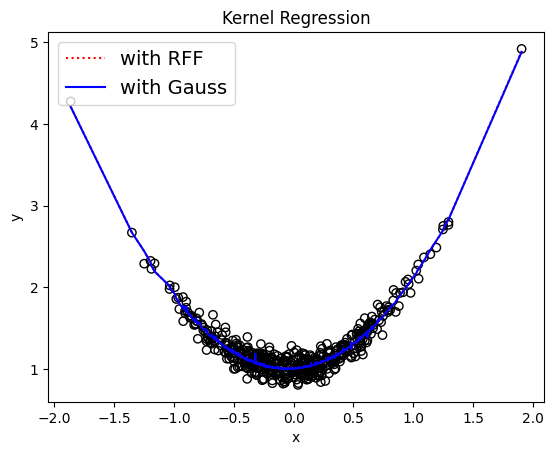

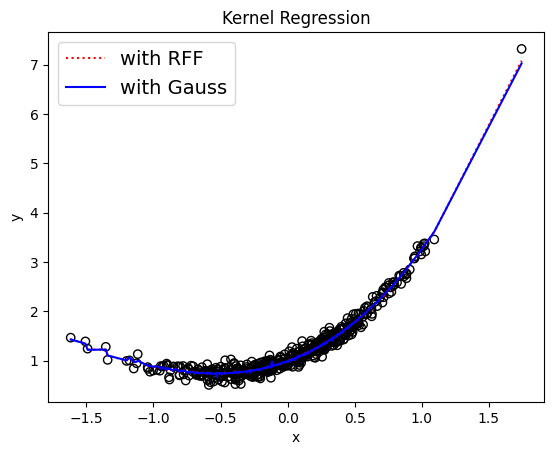

In [48]:
# Plot for x1 and y1
f1_sort_approx = np.array([x for _,x in sorted(zip(x1,function_estimate[0]))])

f = plt.figure(1)
plt.scatter(x1,y1, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(np.sort(x1), f1_sort_approx, c="r", label="with RFF", ls = ":")
plt.plot(np.sort(x1), f1_sort, c="b", label="with Gauss")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
f.show()

# Plot for x2 and y2
f2_sort_approx = np.array([x for _,x in sorted(zip(x2,function_estimate[1]))])

g = plt.figure(2)
plt.scatter(x2,y2, facecolors ='none' , edgecolors = "k" , marker = "o")
plt.plot(np.sort(x2), f2_sort_approx, c="r", label="with RFF", ls = ":")
plt.plot(np.sort(x2), f2_sort, c="b", label="with Gauss")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
g.show()